The goal of this notebook is to check the reproducibility of Mass2Motifs across different MS2LDA runs, and recover them. MS2LDA was run 4 different times with the same parameters except the number of motifs (400, 600, 800, 1000). The idea is based that relevant Mass2Motifs should be reproducible across all these runs, since they represent a actual substructure.

In [1]:
from MS2LDA.motif_parser import load_m2m_folder
from MS2LDA.Add_On.MassQL.MassQL4MotifDB import load_motifDB, motifDB2motifs
from MS2LDA.utils import retrieve_spec4doc

from MS2LDA.Add_On.Fingerprints.FP_annotation import annotate_motifs as calc_fingerprints

import pickle
import tomotopy as tp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

from rdkit.Chem import RDKFingerprint
from rdkit.DataStructs import TanimotoSimilarity
import numpy as np
from tqdm import tqdm
from rdkit import DataStructs
from rdkit.DataStructs.cDataStructs import ExplicitBitVect
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import MolFromSmarts


from typing import Dict, List, Optional
from rdkit.Chem import MolFromSmiles, rdFMCS, RDKFingerprint
from rdkit.DataStructs import TanimotoSimilarity
import numpy as np
from tqdm import tqdm

from collections import defaultdict
from matchms import calculate_scores


In [2]:
import numpy as np
import pandas as pd
from matchms import Spectrum
from matchms.similarity import CosineGreedy


Below the optimized motifsets are loaded and the motifs are transformed into matchms Spectrum objects, which facilitates spectral comparisons between them.

In [3]:
# --- Load motifsets for each run ---
motifDB_1_400, motifDB_2_400 = load_motifDB("/home/ioannis/thesis_data/positive_400/motifset_optimized.json")
motifs_400 = motifDB2motifs(motifDB_2_400)

motifDB_1_600, motifDB_2_600 = load_motifDB("/home/ioannis/thesis_data/positive_600/motifset_optimized.json")
motifs_600 = motifDB2motifs(motifDB_2_600)

motifDB_1_800, motifDB_2_800 = load_motifDB("/home/ioannis/thesis_data/positive_800/motifset_optimized.json")
motifs_800 = motifDB2motifs(motifDB_2_800)

motifDB_1_1000, motifDB_2_1000 = load_motifDB("/home/ioannis/thesis_data/positive_1000/motifset_optimized.json")
motifs_1000 = motifDB2motifs(motifDB_2_1000)


To compare the spectra for each motif, cosine similarity is used.

In [4]:
cosine = CosineGreedy(tolerance=0.01)

MS2LDA optimizes the motifs, doing an internal filtering step. As a result, the motifs that pass this filtering step are fewer that the motifs assigned in the MS2LDA run as shown below.

In [5]:
print("Motifs in K=400:", len(motifs_400))
print("Motifs in K=600:", len(motifs_600))
print("Motifs in K=800:", len(motifs_800))
print("Motifs in K=1000:", len(motifs_1000))

Motifs in K=400: 282
Motifs in K=600: 413
Motifs in K=800: 542
Motifs in K=1000: 637


In [6]:
motifs_600[87].metadata

{'id': 'motif_170',
 'charge': 1,
 'short_annotation': None,
 'annotation': None,
 'ms2accuracy': 0.005,
 'motifset': 'DDA-Suspectlist',
 'motif_id': 'motif_170',
 'analysis_massspectrometer': None,
 'collision_energy': None,
 'other_information': None,
 'scientific_name': None,
 'sample_type': None,
 'massive_id': None,
 'taxon_id': None,
 'analysis_ionizationsource': None,
 'analysis_chromatographyandphase': None,
 'analysis_polarity': None,
 'paper_url': None,
 'auto_annotation': ['CC(=O)NC1C(OC2CCC3(C)C(CCC4(C)C3CC=C3C5CC(C)(C)CCC5(C(=O)OC5OC(CO)C(O)C(O)C5O)CCC34C)C2(C)C)OC(COC2OCC(O)C(O)C2OC2OCC(O)C(O)C2O)C(O)C1O',
  'CC(=O)NC1C(OC2CCC3(C)C(CCC4(C)C3CC=C3C5CC(C)(C)CCC5(C(=O)O)C(O)CC34C)C2(C)C)OC(COC2OCC(O)C(O)C2OC2OCC(O)C(O)C2O)C(O)C1O',
  'CC(=O)NC1C(OC2CCC3(C)C(CCC4(C)C3CC=C3C5CC(C)(C)CCC5(C(=O)O)C(OC5OC(CO)C(O)C(O)C5O)CC34C)C2(C)C)OC(COC2OCC(O)C(O)C2OC2OCC(O)C(O)C2O)C(O)C1O',
  'CC(=O)NC1C(OC2CCC3(C)C(CCC4(C)C3CC=C3C5CC(C)(C)CCC5(C(=O)OC5OCC(O)C(O)C5O)CCC34C)C2(C)C)OC(COC2OC(C)

In order to investigate the reproducibility of the motifs across the 4 different MS2LDA runs, the motifs from the 400 run that are also the fewest will be used as anchors. So for every optimized motif in the 400 run, the best analogous motif from the other 3 runs will be found, using cosine similarity as the comparison metric.

In [7]:
records = []

scores_400_600 = calculate_scores(motifs_400, motifs_600, cosine)
scores_400_800 = calculate_scores(motifs_400, motifs_800, cosine)
scores_400_1000 = calculate_scores(motifs_400, motifs_1000, cosine)

for spec_400 in motifs_400:
    motif_id_400 = spec_400.metadata["motif_id"]

    # best match in 600
    row_600 = scores_400_600.scores_by_reference(spec_400, "CosineGreedy_score")
    if len(row_600) == 0:
        best_600_id = None
        score_600 = 0.0
    else:
        best_600_spec, best_600_score = max(row_600, key=lambda x: x[1][0])
        best_600_id = best_600_spec.metadata["motif_id"]
        score_600 = best_600_score[0]

    # best match in 800
    row_800 = scores_400_800.scores_by_reference(spec_400, "CosineGreedy_score")
    if len(row_800) == 0:
        best_800_id = None
        score_800 = 0.0
    else:
        best_800_spec, best_800_score = max(row_800, key=lambda x: x[1][0])
        best_800_id = best_800_spec.metadata["motif_id"]
        score_800 = best_800_score[0]

    # best match in 1000
    row_1000 = scores_400_1000.scores_by_reference(spec_400, "CosineGreedy_score")
    if len(row_1000) == 0:
        best_1000_id = None
        score_1000 = 0.0
    else:
        best_1000_spec, best_1000_score = max(row_1000, key=lambda x: x[1][0])
        best_1000_id = best_1000_spec.metadata["motif_id"]
        score_1000 = best_1000_score[0]

    mean_score = (score_600 + score_800 + score_1000) / 3

    records.append({
        "motif_400": motif_id_400,
        "best_600": best_600_id,
        "score_600": score_600,
        "best_800": best_800_id,
        "score_800": score_800,
        "best_1000": best_1000_id,
        "score_1000": score_1000,
        "mean_score": mean_score
    })

reproducibility_400 = pd.DataFrame(records)




In [8]:
print(reproducibility_400)

     motif_400   best_600  score_600   best_800  score_800  best_1000  \
0    motif_399  motif_186   1.000000  motif_166   1.000000  motif_134   
1     motif_79  motif_421   1.000000  motif_412   1.000000  motif_863   
2     motif_99  motif_498   0.304669  motif_350   0.304669  motif_751   
3    motif_238  motif_309   0.004648  motif_172   1.000000  motif_849   
4    motif_359  motif_586   0.636943   motif_42   1.000000  motif_518   
..         ...        ...        ...        ...        ...        ...   
277  motif_268  motif_317   0.867572  motif_741   0.867323  motif_126   
278   motif_21  motif_167   0.953101  motif_133   0.999078  motif_530   
279  motif_307  motif_197   0.908227  motif_479   0.722172  motif_601   
280  motif_366  motif_145   0.929212       None   0.000000  motif_692   
281   motif_42       None   0.000000       None   0.000000  motif_242   

     score_1000  mean_score  
0      1.000000    1.000000  
1      1.000000    1.000000  
2      0.947338    0.518892  
3  

The graph shows a clear reproducibility, since half of the groups of motifs have mean cosine spectral similarity greater than 95%

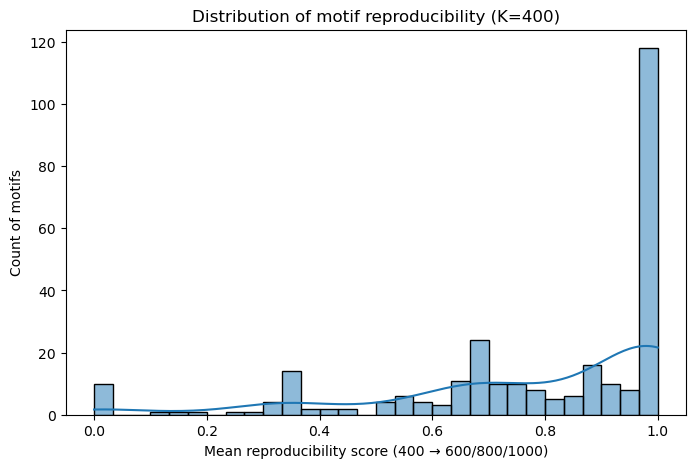

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(reproducibility_400["mean_score"], bins=30, kde=True)
plt.xlabel("Mean reproducibility score (400 → 600/800/1000)")
plt.ylabel("Count of motifs")
plt.title("Distribution of motif reproducibility (K=400)")
plt.show()


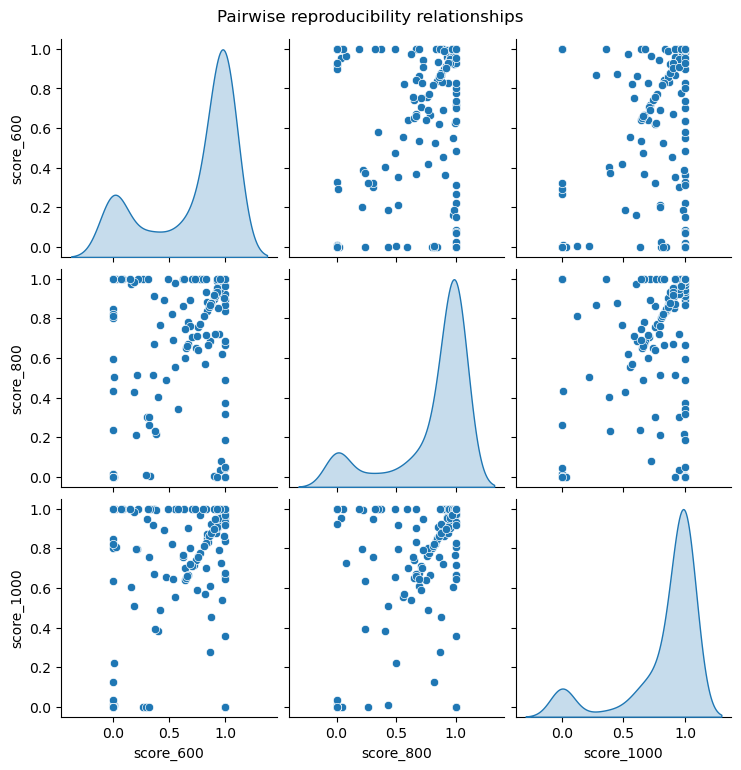

In [10]:
sns.pairplot(
    reproducibility_400[["score_600", "score_800", "score_1000"]],
    diag_kind="kde"
)
plt.suptitle("Pairwise reproducibility relationships", y=1.02)
plt.show()


Now in order, to manually curate these motifs, a dataframe was made with all the important information such as motif_ids and best cosine similarity scores. Last step of this process is the creation of excel files that will facilitate the research of each user.

In [ ]:
reproducibility_400["present_in_all_runs"] = (
    (reproducibility_400["score_600"] > 0) &
    (reproducibility_400["score_800"] > 0) &
    (reproducibility_400["score_1000"] > 0)
)

reproducibility_400["high_reproducibility"] = (
    (reproducibility_400["mean_score"] >= 0.95) &
    (reproducibility_400["present_in_all_runs"])
)


Reproducible groups of motifs (groups of 4, one motif from each run) that >= 95% cosine similarity.

In [24]:
n_high_95 = reproducibility_400["high_reproducibility"].sum()
print("Motif-groups present in all runs with mean_score ≥ 0.95:", n_high_95)

Motif-groups present in all runs with mean_score ≥ 0.95: 123


Reproducible groups of motifs (groups of 4, one motif from each run) that >= 90% cosine similarity.

In [25]:
reproducibility_400["present_in_all_runs"] = (
    (reproducibility_400["score_600"] > 0) &
    (reproducibility_400["score_800"] > 0) &
    (reproducibility_400["score_1000"] > 0)
)

reproducibility_400["high_reproducibility"] = (
    (reproducibility_400["mean_score"] >= 0.9) &
    (reproducibility_400["present_in_all_runs"])
)


In [26]:
n_high_90 = reproducibility_400["high_reproducibility"].sum()
print("Motifs present in all runs with mean_score ≥ 0.90:", n_high_90)

Motifs present in all runs with mean_score ≥ 0.90: 136


In [ ]:
anchors_400_90 = reproducibility_400[reproducibility_400["high_reproducibility"]].copy()
anchors_400_90.to_excel("stable_motifs_90.xlsx", index=False)